In [1]:
from skimage.io import imread_collection
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings(action="ignore")


In [2]:
# The test set will be used for independent validation

normal_dir = [
    'chest_xray/train/NORMAL',
    'chest_xray/val/NORMAL',
]

pneumonia_dir = [
    'chest_xray/train/PNEUMONIA',
    'chest_xray/val/PNEUMONIA'
]


In [3]:
filepaths = []
labels = []
dict_lists = [normal_dir, pneumonia_dir]
class_labels = ['NORMAL', 'PNEUMONIA']

In [4]:
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

In [5]:
file_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
pneumonia_normal_df = pd.DataFrame(pd.concat([file_series, label_series], axis=1))

In [6]:
pneumonia_normal_df['label'].value_counts()

label
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64

In [8]:
train_df, test_df = train_test_split(pneumonia_normal_df, test_size=0.3, random_state=42, stratify=pneumonia_normal_df['label'])

In [9]:
test_df['label'].value_counts()

label
PNEUMONIA    1165
NORMAL        405
Name: count, dtype: int64

In [10]:
random_index = random.randint(0, len(train_df['filepath']) - 1)
random_image = cv2.imread(train_df['filepath'].loc[random_index])
random_image.shape

(1314, 1690, 3)

In [11]:
image_generator = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label", 
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)


Found 3662 validated image filenames belonging to 2 classes.
Found 1570 validated image filenames belonging to 2 classes.


In [12]:
print(next(train_generator))

(array([[[[-0.6156863 , -0.6156863 , -0.6156863 ],
         [-0.6       , -0.6       , -0.6       ],
         [-0.5529412 , -0.5529412 , -0.5529412 ],
         ...,
         [-0.4980392 , -0.4980392 , -0.4980392 ],
         [-0.36470586, -0.36470586, -0.36470586],
         [-0.20784312, -0.20784312, -0.20784312]],

        [[-0.6       , -0.6       , -0.6       ],
         [-0.5921569 , -0.5921569 , -0.5921569 ],
         [-0.5372549 , -0.5372549 , -0.5372549 ],
         ...,
         [-0.4588235 , -0.4588235 , -0.4588235 ],
         [-0.36470586, -0.36470586, -0.36470586],
         [-0.23137254, -0.23137254, -0.23137254]],

        [[-0.6392157 , -0.6392157 , -0.6392157 ],
         [-0.60784316, -0.60784316, -0.60784316],
         [-0.5529412 , -0.5529412 , -0.5529412 ],
         ...,
         [-0.45098037, -0.45098037, -0.45098037],
         [-0.36470586, -0.36470586, -0.36470586],
         [-0.27058822, -0.27058822, -0.27058822]],

        ...,

        [[-0.8509804 , -0.8509804 , -

In [13]:
image_size=(224,224)
input_channels=3
image_shape=(image_size[0], image_size[1], input_channels)

In [33]:
model = Sequential([
    Conv2D(filters=64,
           kernel_size=(5,5),
           padding='same',
           activation='relu',
           input_shape=image_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=128,
           kernel_size=(3,3),
           padding='same',
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=256,
           kernel_size=(3,3),
           padding='same',
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512,
           kernel_size=(3,3),
           padding='same',
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dropout(0.3),
    Dense(256,
          activation='relu'),
    Dropout(0.3),
    Dense(2, 
          activation='softmax')
])

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,248,770 (103.95 MB)

 Trainable params: 27,246,850 (103.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

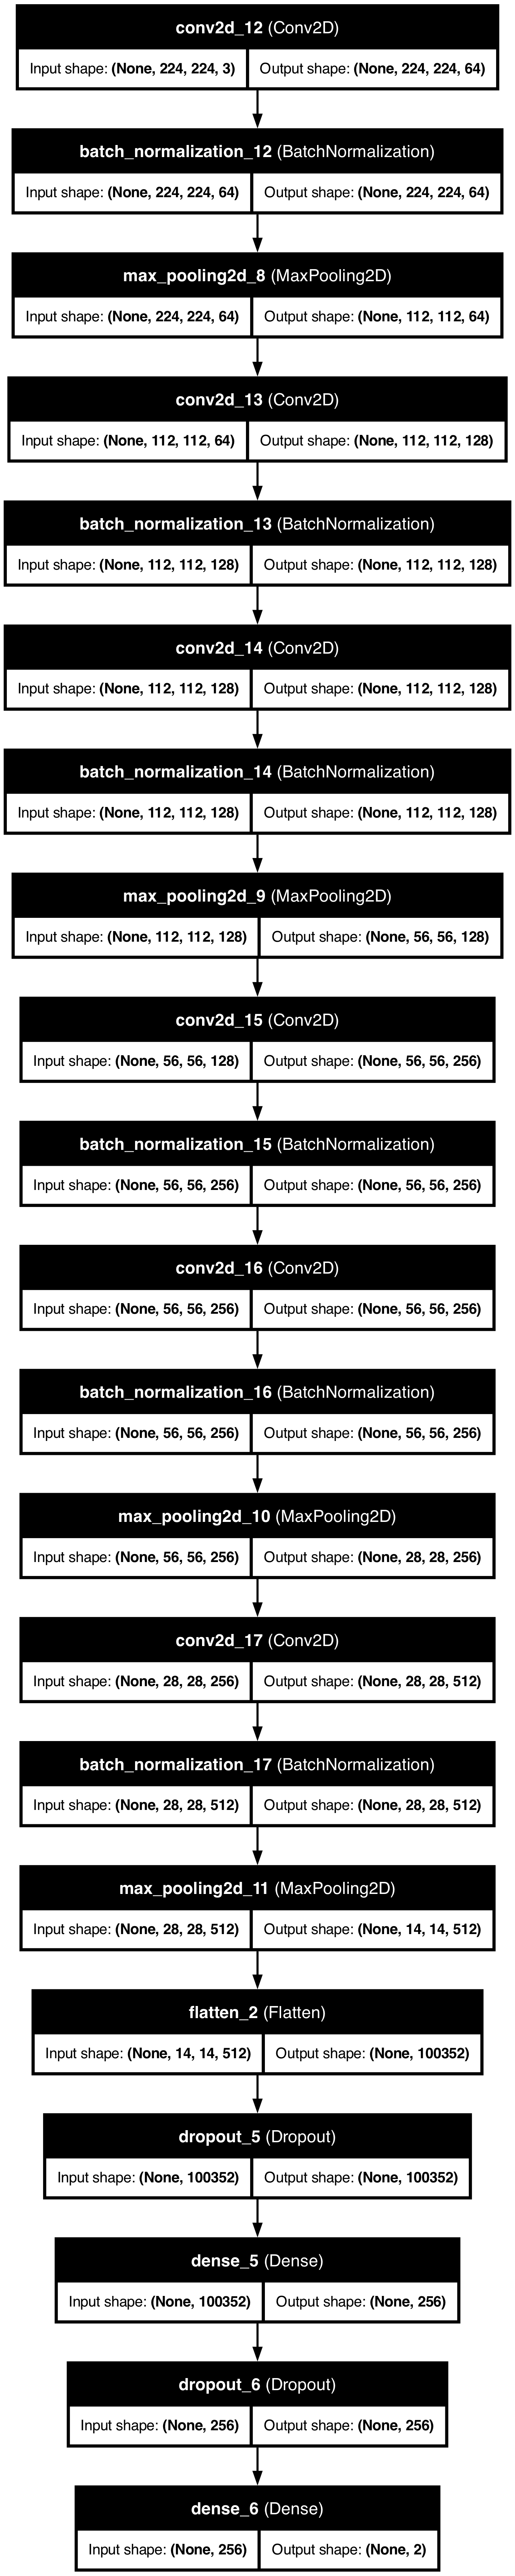

In [22]:
#plotting model architecture
plot_model(model, to_file='model_architecture_plot.png', show_shapes=True, show_layer_names=True)

In [37]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[checkpoint])

Epoch 1/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8783 - loss: 2.3498
Epoch 1: val_accuracy improved from -inf to 0.95989, saving model to best_model.keras
524/524 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.8783 - loss: 2.3472 - val_accuracy: 0.9599 - val_loss: 0.1356
Epoch 2/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9457 - loss: 0.2328
Epoch 2: val_accuracy improved from 0.95989 to 0.96562, saving model to best_model.keras
524/524 ━━━━━━━━━━━━━━━━━━━━ 700s 1s/step - accuracy: 0.9457 - loss: 0.2327 - val_accuracy: 0.9656 - val_loss: 0.1059
Epoch 3/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9482 - loss: 0.1581
Epoch 3: val_accuracy did not improve from 0.96562
524/524 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.9482 - loss: 0.1582 - val_accuracy: 0.8529 - val_loss: 0.9775
Epoch 4/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9213 - loss: 0.2425
Epoch 4: val_accuracy did not improve from 0.96562
524/524 ━━━━━━━━━━━━━━━━━━━━ 687s

In [38]:
#for 10 epochs
model.evaluate(test_generator, verbose=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 287ms/step - accuracy: 0.9658 - loss: 0.0825


[0.10267823189496994, 0.9723018407821655]

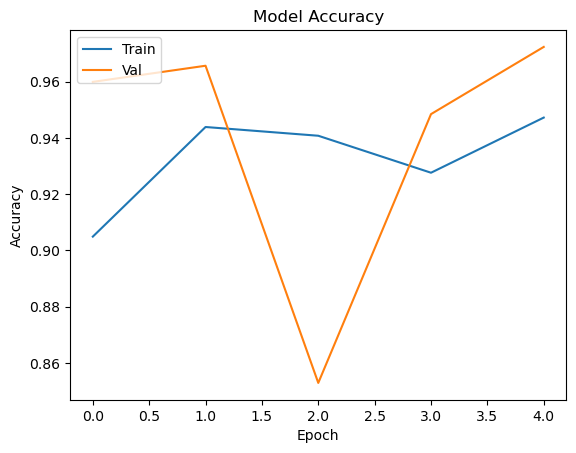

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

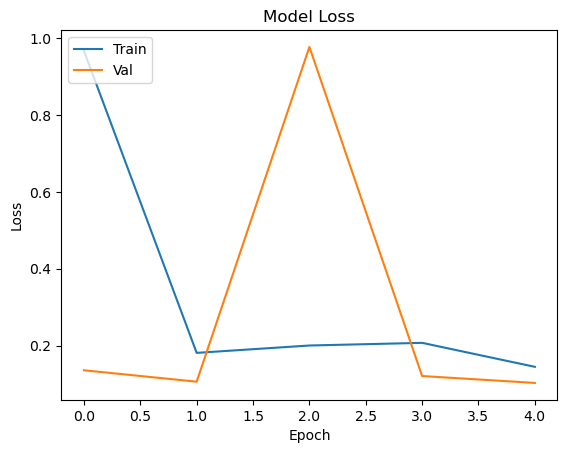

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [41]:
pred = np.argmax(model.predict(test_generator) , axis = 1)
y_test=test_generator.labels

131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 295ms/step


In [42]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.27      0.27      0.27       270
           1       0.75      0.75      0.75       777

    accuracy                           0.63      1047
   macro avg       0.51      0.51      0.51      1047
weighted avg       0.62      0.63      0.63      1047



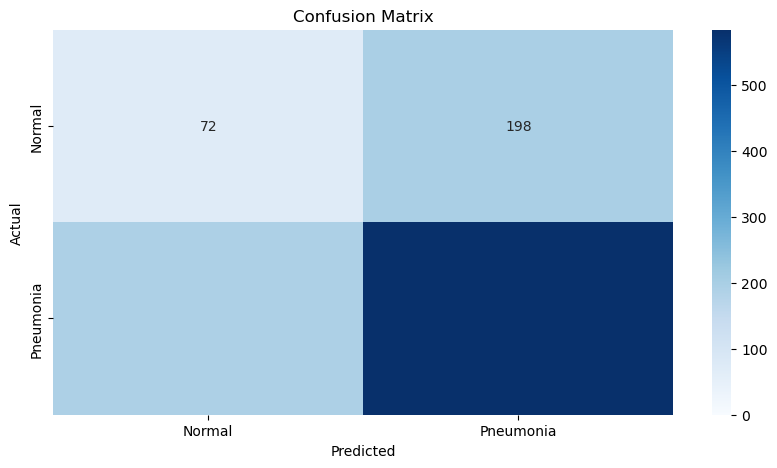

In [43]:
class_labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [26]:
def generate_confusion_matrix(y, pred, type):
    cm = confusion_matrix(y, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix ({type} Data)')
    plt.show()

## Basic model

In [52]:
basic_model= Sequential([
    Conv2D(32, (3,3), input_shape=image_shape, activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation='softmax')
])


In [53]:
basic_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
basic_history = basic_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 130s 141ms/step - accuracy: 0.8658 - loss: 0.3399 - val_accuracy: 0.9363 - val_loss: 0.1801
Epoch 2/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 145s 159ms/step - accuracy: 0.9545 - loss: 0.1292 - val_accuracy: 0.9720 - val_loss: 0.0846
Epoch 3/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 141s 154ms/step - accuracy: 0.9714 - loss: 0.0775 - val_accuracy: 0.9611 - val_loss: 0.0924
Epoch 4/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 148s 161ms/step - accuracy: 0.9770 - loss: 0.0625 - val_accuracy: 0.9713 - val_loss: 0.0770
Epoch 5/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 145s 158ms/step - accuracy: 0.9796 - loss: 0.0525 - val_accuracy: 0.9752 - val_loss: 0.0749


916/916 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step


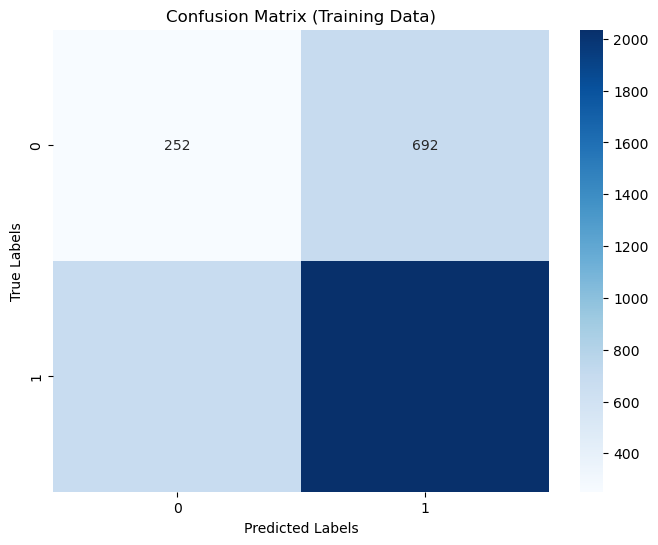

In [17]:
#We want to verify if our model hasn't overfit to the training data, i.e., if its 
#performance on new data, such as the test set, is comparable to that on the training set.

y_train=train_generator.labels
y_train_pred = np.argmax(basic_model.predict(train_generator) , axis = 1)

generate_confusion_matrix(y_train, y_train_pred, 'Training')

In [18]:
#classification report for test set
pred = np.argmax(basic_model.predict(test_generator) , axis = 1)
y_test=test_generator.labels
print(classification_report(pred, y_test))

393/393 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step
              precision    recall  f1-score   support

           0       0.26      0.26      0.26       408
           1       0.74      0.74      0.74      1162

    accuracy                           0.62      1570
   macro avg       0.50      0.50      0.50      1570
weighted avg       0.62      0.62      0.62      1570



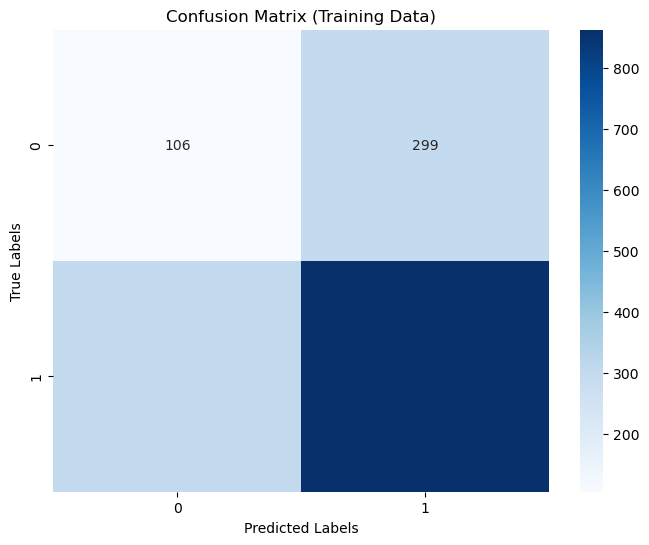

In [21]:
generate_confusion_matrix(y_test, pred, 'Test')

Weak prediction on both classes, primarily one, has been observed on the simple neural network. Therefore, we will now attempt to expand the neural network. The results on the test and training data are similar, indicating that the model is well-trained

## Adding BatchNormalization

In [22]:
bn_model= Sequential([
    Conv2D(32, (3,3), input_shape=image_shape, activation="relu", padding='same', strides=1),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation="relu", padding='same', strides=1),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation="relu", padding='same', strides=1),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation="relu", padding='same', strides=1),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation='softmax')
])


In [23]:
bn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
bn_history = bn_model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 191s 207ms/step - accuracy: 0.8787 - loss: 1.1505 - val_accuracy: 0.9140 - val_loss: 0.2384
Epoch 2/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 199s 218ms/step - accuracy: 0.9409 - loss: 0.1781 - val_accuracy: 0.8968 - val_loss: 0.2525
Epoch 3/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 195s 212ms/step - accuracy: 0.9453 - loss: 0.2465 - val_accuracy: 0.9662 - val_loss: 0.1005
Epoch 4/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 206s 225ms/step - accuracy: 0.9657 - loss: 0.0931 - val_accuracy: 0.9713 - val_loss: 0.0847
Epoch 5/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 202s 220ms/step - accuracy: 0.9748 - loss: 0.0751 - val_accuracy: 0.9465 - val_loss: 0.1262


In [27]:
#classification report for test set
bn_pred = np.argmax(bn_model.predict(test_generator) , axis = 1)
y_test=test_generator.labels
print(classification_report(bn_pred, y_test))

393/393 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step
              precision    recall  f1-score   support

           0       0.20      0.25      0.23       329
           1       0.79      0.74      0.76      1241

    accuracy                           0.64      1570
   macro avg       0.50      0.50      0.50      1570
weighted avg       0.67      0.64      0.65      1570



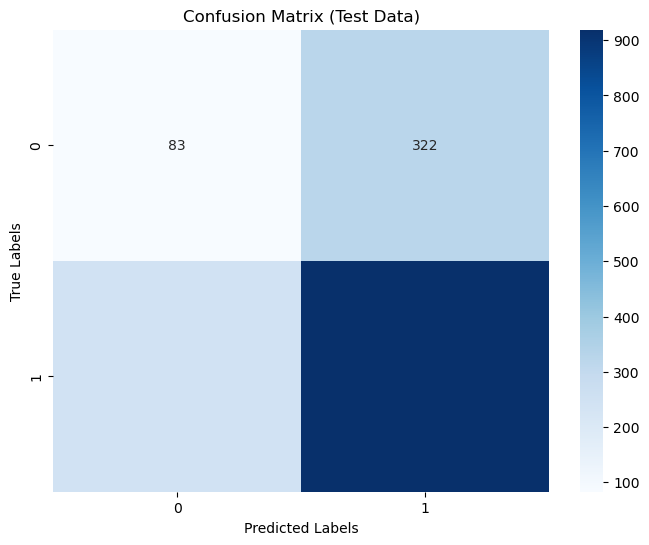

In [28]:
generate_confusion_matrix(y_test, bn_pred, 'Test')

916/916 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step


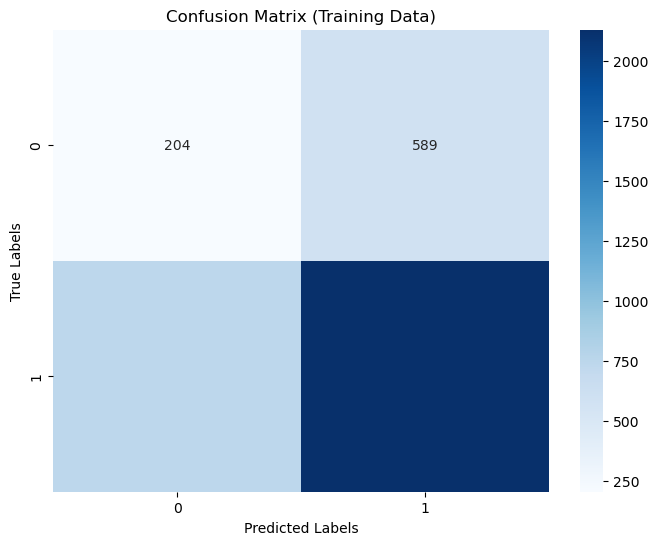

In [31]:
generate_confusion_matrix(np.argmax(bn_model.predict(train_generator) , axis = 1), y_train, 'Training')

For the subsequent model training, we will set the batch size parameter to 16 (batch_size = 16) to expedite the convergence process.

In [54]:
image_generator = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label", 
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 3662 validated image filenames belonging to 2 classes.
Found 1570 validated image filenames belonging to 2 classes.


In [55]:
basic_history = basic_model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 114s 493ms/step - accuracy: 0.8117 - loss: 0.4513 - val_accuracy: 0.9637 - val_loss: 0.0957
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 129s 560ms/step - accuracy: 0.9648 - loss: 0.0990 - val_accuracy: 0.9764 - val_loss: 0.0677
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 127s 550ms/step - accuracy: 0.9807 - loss: 0.0555 - val_accuracy: 0.9758 - val_loss: 0.0753
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 125s 543ms/step - accuracy: 0.9804 - loss: 0.0569 - val_accuracy: 0.9745 - val_loss: 0.0749
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 125s 543ms/step - accuracy: 0.9844 - loss: 0.0380 - val_accuracy: 0.9783 - val_loss: 0.0637
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 129s 562ms/step - accuracy: 0.9867 - loss: 0.0409 - val_accuracy: 0.9694 - val_loss: 0.0962
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 128s 556ms/step - accuracy: 0.9896 - loss: 0.0262 - val_accuracy: 0.9828 - val_loss: 0.0815
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 127s 552ms/step - accuracy: 0.9922 -

99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step


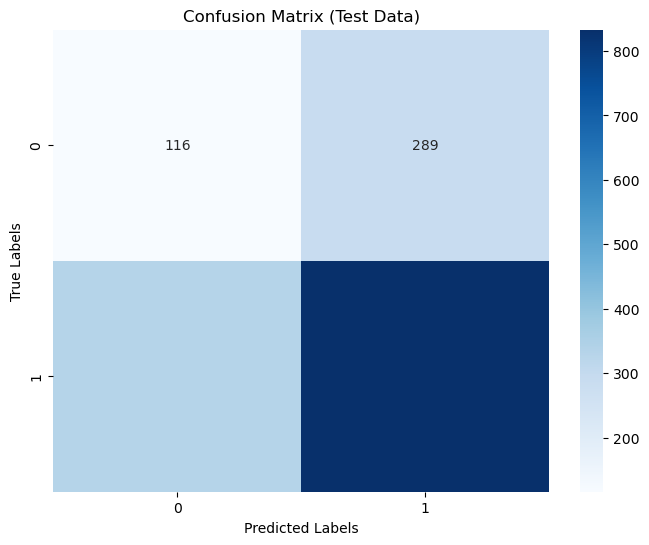

In [56]:
y_pred_basic_batch16 = np.argmax(basic_model.predict(test_generator), axis=1)
generate_confusion_matrix(y_test, y_pred_basic_batch16, 'Test')

In [57]:
print(classification_report(y_pred_basic_batch16, y_test))

              precision    recall  f1-score   support

           0       0.29      0.26      0.27       448
           1       0.72      0.74      0.73      1122

    accuracy                           0.60      1570
   macro avg       0.50      0.50      0.50      1570
weighted avg       0.59      0.60      0.60      1570

